# Vision

In [ ]:

from ViT_explanation_generator import LRP, LRP_RAP
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler
from tqdm import tqdm
import json
from torchvision import datasets
import argparse
from PIL import Image
import torch
from samples.CLS2IDX import CLS2IDX
import numpy as np
import matplotlib.pyplot as plt
import os
import config
from misc.helper_functions import is_valid_directory ,create_directory_if_not_exists, update_json
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from models.model_visualizations import deit_tiny_patch16_224 as vit_LRP
from models.model_visualizations import deit_base_patch16_224 as vit_LRP_base
from models.model_visualizations import deit_small_patch16_224 as vit_LRP_small
from modules.layers_ours import *
from functools import partial




import cv2
normalize = transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

def model_handler(pretrained=False,size = "tiny" , hooks = False,  **kwargs):
        if size == 'base':
            return vit_LRP_base(

                    num_classes     = 1000,
                    pretrained      = pretrained,
                    activation      = GELU(),
                    layer_norm      = partial(CustomLRPLayerNorm, eps=1e-6),
                    last_norm       = CustomLRPLayerNorm
            )
        elif size == 'small':
            return vit_LRP_small(
                    num_classes     = 1000,
                    pretrained      = pretrained,
                    activation      = GELU(),
                    layer_norm      = partial(CustomLRPLayerNorm, eps=1e-6),
                    last_norm       = CustomLRPLayerNorm
            )
        return vit_LRP(
                   num_classes     = 1000,
                   pretrained      = pretrained,
                   activation      = GELU(),
                   layer_norm      = partial(CustomLRPLayerNorm, eps=1e-6),
                   last_norm       = CustomLRPLayerNorm

            )


def print_top_classes(predictions, **kwargs):
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])

    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)



def concatenate_images_with_gaps(images, gap_size=10):

    # Get dimensions
    height = 224  # As specified in the requirements
    width = 224   # As specified in the requirements
    channels = 3  # RGB channels
    n_images = len(images)
    caption_height=30
    total_height = height + caption_height

    # Create empty array for the combined image with white background
    total_width = (n_images * width) + ((n_images - 1) * gap_size)
    combined_image = np.ones((total_height, total_width, channels), dtype=np.float32)
    captions = ["","Ours","AttnLRP","Only PE"]
    # Place each image with gaps
    current_position = 0
    for i,img in enumerate(images):
        # Ensure image is the correct size
        if img.shape != (height, width, channels):
            img = np.resize(img, (height, width, channels))

        # Place the image
        combined_image[:height, current_position:current_position + width, :] = img
        import cv2
        caption = captions[i]
        # Create a temporary image just for the text
        text_region = combined_image[height:, current_position:current_position + width, :]
        # Add text to the caption area
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1
        text_color = (255, 255, 255)  # Black text

        # Calculate text position to center it
        text_size = cv2.getTextSize(caption, font, font_scale, font_thickness)[0]
        text_x = current_position + (width - text_size[0]) // 2
        text_y = height + (caption_height + text_size[1]) // 2

        cv2.putText(combined_image, caption, (text_x, text_y),
                    font, font_scale, text_color, font_thickness)

        current_position += width + gap_size

    return combined_image

def show_cam_on_image(img, mask):

    x = np.uint8(255 * mask)

    heatmap = cv2.applyColorMap(x, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam


def generate_visualization_custom_LRP(original_image, class_index=None, method = None,  prop_rules = None, save_dir = None, posLens = False,  save_images_dir = None,batch_idx=None):
    res = []

    attributions = attribution_generator.generate_LRP(original_image.cuda(), prop_rules = prop_rules, method=method, cp_rule=True,  index=class_index)

    image_transformer_attribution = original_image[0].permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())


    image_copy = 255 *image_transformer_attribution
    image_copy = image_copy.astype('uint8')
    attributions = [elem[0,:] for elem in attributions]
    vis = [None,None,None]

    for i in range(3):
        attributions[i] = attributions[i].reshape(14, 14).unsqueeze(0).unsqueeze(0)
        attributions[i] = torch.nn.functional.interpolate(attributions[i], scale_factor=16, mode='bilinear', align_corners=False)
        attributions[i] = attributions[i].squeeze().detach().cpu().numpy()
        attributions[i] = (attributions[i] - attributions[i].min()) / (attributions[i].max() - attributions[i].min())
        vis[i] = show_cam_on_image(image_transformer_attribution, attributions[i])
        vis[i] =  np.uint8(255 * vis[i])
        vis[i] = cv2.cvtColor(np.array(vis[i]), cv2.COLOR_RGB2BGR)

    conc_imgs = concatenate_images_with_gaps([image_copy, vis[0], vis[1], vis[2]])
    conc_imgs = conc_imgs.astype('uint8')
    plt.imsave(f"{save_dir}/output.png" , conc_imgs)
    return conc_imgs


prop_rules = {
    'epsilon_rule' : False,
    'conv_gamma_rule'  :  False,
    'linear_gamma_rule'  :False,
    "linear_alpha_rule" : 1,
    "default_op"   : False,
}

save_dir = f"samples/"
output_dir = f"output/"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(output_dir , exist_ok=True)









Choose your image here

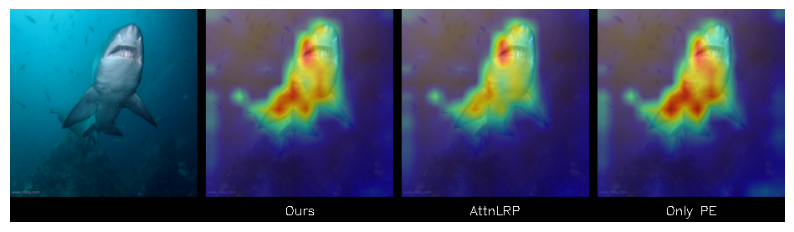

In [ ]:

image = "samples/img1.png"
image = "samples/img2.png"
size  = "tiny"



model = model_handler(pretrained = True,
                      size       = size,
                      hooks      = True)


model.cuda()
model.eval()
attribution_generator = LRP(model)



image = Image.open(image).convert('RGB')
image_transformed = transform(image)
output = generate_visualization_custom_LRP(image_transformed.unsqueeze(0).cuda() ,
                                             None,
                                             prop_rules = prop_rules,
                                             method = "custom_lrp",
                                             save_dir = output_dir,

                                           )

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(output)